In [1]:
from galactic import GalacticDataset

Let's use a variant of the Alpaca fine-tuning dataset, with responses generated by GPT-4. We'll take 10,000 examples. As it turns out, there's lots of redundant instructions even in this small subset--Galactic will help us find and pare it down.

In [2]:
ds = GalacticDataset.from_hugging_face(
    "vicgalle/alpaca-gpt4",
    split="train"
).select(range(10000))

We'll embed the "instruction" field, as we want to organize/cluster the data by the sort of queries the user is asking of the model. To save time, we'll use the OpenAI API for embeddings, but if you choose `backend='cpu'`, you can do this right on your computer too!

In [3]:
# have to do this to run async routines (like the openai api) in jupyter
import nest_asyncio
nest_asyncio.apply()

ds.set_openai_key(open("/Users/ben/Desktop/oai_api_key.txt").read().strip())
ds.set_rate_limits(
    max_requests_per_minute=3000,
    max_tokens_per_minute=500_000
)
ds.get_embeddings(input_field="instruction", backend="openai");

Parameter 'function'=<function get_embeddings.<locals>._embed_batch at 0x139c06200> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

INFO: Parallel processing complete.
INFO: Requests left: 7000
INFO: Parallel processing complete.
INFO: Requests left: 4000
INFO: Parallel processing complete.
INFO: Requests left: 1000
INFO: Parallel processing complete.
INFO: Requests left: 0
INFO: Created embeddings on field 'instruction', stored in '__embedding'.


                                         instruction  \
0               Give three tips for staying healthy.   
1                 What are the three primary colors?   
2                 Describe the structure of an atom.   
3                   How can we reduce air pollution?   
4  Describe a time when you had to make a difficu...   
5                          Identify the odd one out.   
6  Explain why the following fraction is equivale...   
7  Write a short story in third person narration ...   
8                       Render a 3D model of a house   
9  Evaluate this sentence for spelling and gramma...   

                                          input  \
0                                                 
1                                                 
2                                                 
3                                                 
4                                                 
5                  Twitter, Instagram, Telegram   
6                         

Alright! Now that we have embeddings, we can cluster the dataset. Sometimes, clustering can be more effective if we first reduce the dimensionality of the embeddings. We'll use PCA to reduce the dimensionality from 1536 to 50.

In [6]:
ds.reduce_embedding_dim(
    n_dims=50,
    method="pca"
); # <- semicolon to suppress output

INFO: Reduced embeddings to 50 dimensions using pca. New embeddings stored in column '__embedding_pca_50'


Now that we have new embeddings in the `__embedding_pca_50` column, these can be used to cluster the dataset. We'll use the `BisectingKMeans` algorithm, which is a variant of K-Means that tends to produce more evenly-sized clusters (because at each step, it forms new clusters by bisecting an existing cluster). Galactic also supports vanilla K-Means and HDBSCAN (which is recommended if you used UMAP before clustering).

In order to use the right column (rather than the default `__embedding` column), we have to pass the embedding field as an argument.

In [7]:
ds.cluster(
    n_clusters=30,
    method="bisecting_kmeans",
    embedding_field="__embedding_pca_50"
);

Let's get some basic information about these clusters. Note that we have to pass the embedding field used for clustering, otherwise the `cluster_info` function will use the default `__embedding` column to find nearest neighbors, which will fail because it's 1536 dimensions, while cluster centers are 50.

In [8]:
info = ds.get_cluster_info(embedding_field="__embedding_pca_50", context_fields=["instruction"])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Cluster 14 (346 items)
### Example 1
	- instruction: List five healthy eating habits.
### Example 2
	- instruction: Name the five main food groups.
### Example 3
	- instruction: List five items that girls need for a camping trip.
Cluster 12 (422 items)
### Example 1
	- instruction: Name three famous European landmarks
### Example 2
	- instruction: Name five countries with the most number of UNESCO World Heritage sites.
### Example 3
	- instruction: Name three countries in Europe.
Cluster 16 (402 items)
### Example 1
	- instruction: What is the difference between an atom and a molecule?
### Example 2
	- instruction: What is the difference between cellular respiration and fermentation?
### Example 3
	- instruction: Explain the differences between two different things.
Cluster 17 (319 items)
### Example 1
	- instruction: How can renewable energy reduce environmental pollution?
### Example 2
	- instruction: What are some ways to reduce air pollution?
### Example 3
	- instruction: Propose t

This gives us some color on what's going on in each cluster based on its central examples, but it's not easy to read, and it's not exhaustive (a few examples from each cluster may or may not be representative). This also isn't super-scalable to large numbers of clusters or big clusters. Something more scalable: using LLMs to help label clusters. Let's try that!

In [9]:
ds.ai_label_clusters(
    new_column="cluster_label",
    context_fields=["instruction"],
    cluster_field="__cluster",
    embedding_field = "__embedding_pca_50", # it's important to use the same embedding used to create the cluster. doesn't matter if using "random" selection
    n_examples=25,
    selection="random",
    prompt=None,  # use the default prompt
)

INFO: Splitting dataset into clusters... (this might take a bit).


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

  0%|          | 0/30 [00:00<?, ?it/s]

INFO: Parallel processing complete.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

                                         instruction  \
0               Give three tips for staying healthy.   
1                 What are the three primary colors?   
2                 Describe the structure of an atom.   
3                   How can we reduce air pollution?   
4  Describe a time when you had to make a difficu...   
5                          Identify the odd one out.   
6  Explain why the following fraction is equivale...   
7  Write a short story in third person narration ...   
8                       Render a 3D model of a house   
9  Evaluate this sentence for spelling and gramma...   

                                          input  \
0                                                 
1                                                 
2                                                 
3                                                 
4                                                 
5                  Twitter, Instagram, Telegram   
6                         

We can now see that some clusters have clear themes, while others don't (the default prompt instructs the model to say there's no clear theme if there isn't one).

In [13]:
from collections import Counter
Counter(ds["cluster_label"])

Counter({'No shared topic or theme': 493,
         'Language editing and rewriting': 380,
         'Productivity and improvement in various areas.': 320,
         'Text summarization and summarizing instructions.': 314,
         'Education and learning': 309,
         'Instructions for language and grammar tasks.': 293,
         'Language and Word Skills': 263,
         'No shared topic or theme.': 257,
         'Language and creative expression.': 255,
         'Geography and general knowledge': 234,
         'Sentence classification': 207,
         'Writing prompts and instructions.': 204,
         'Technology and Information Technology': 195,
         'Digital Marketing and Business Strategy': 192,
         'Tasks and instructions for various assignments and projects.': 186,
         'Mathematics and Measurement': 181,
         'Procedures/instructions for various activities': 148,
         'Creative Writing Prompts': 130,
         'Sentence rewriting and modification': 108,
       

Another thing we could notice from looking at central points in each cluster is that there's a lot of redundancy! We can use semantic deduplication to remove examples that have the same meaning, to leave us with a smaller, diverse dataset. Let's give that a try. We'll target retaining 50% of the data (this will be tuned on a few clusters, so it won't be perfect).

In [10]:
ds.semdedup(
    target_retention=0.5,
    embedding_field="__embedding_pca_50",
    cluster_field="__cluster",
    num_tuning_clusters=6,
    dedup_strategy="random",
    inplace=True,
);

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

INFO: Tuning threshold on 6 clusters...


Minimum similarity: -0.046780095377139515 Maximum similarity: 0.1999356168230022
Threshold: 0.077, Retention: 0.151
Threshold: 0.138, Retention: 0.962
Threshold: 0.107, Retention: 0.633
Threshold: 0.092, Retention: 0.356
Threshold: 0.1, Retention: 0.502
Minimum similarity: -0.038953075042085554 Maximum similarity: 0.19029590306389688
Threshold: 0.076, Retention: 0.159
Threshold: 0.133, Retention: 0.889
Threshold: 0.104, Retention: 0.576
Threshold: 0.09, Retention: 0.363
Threshold: 0.097, Retention: 0.469
Threshold: 0.101, Retention: 0.538
Threshold: 0.099, Retention: 0.493
Minimum similarity: -0.03884765243450339 Maximum similarity: 0.1988026745014787
Threshold: 0.08, Retention: 0.157
Threshold: 0.139, Retention: 0.952
Threshold: 0.11, Retention: 0.595
Threshold: 0.095, Retention: 0.337
Threshold: 0.102, Retention: 0.474
Threshold: 0.106, Retention: 0.542
Threshold: 0.104, Retention: 0.513
Threshold: 0.103, Retention: 0.497
Minimum similarity: -0.02945998350349817 Maximum similarity: 0

INFO: Threshold: 0.1
INFO: Cluster 14 has 198 duplicates (57.2%).

INFO: Cluster 12 has 188 duplicates (44.5%).

INFO: Cluster 16 has 93 duplicates (23.1%).

INFO: Cluster 17 has 259 duplicates (81.2%).

INFO: Cluster 10 has 162 duplicates (55.5%).

INFO: Cluster 29 has 133 duplicates (42.4%).

INFO: Cluster 28 has 285 duplicates (85.3%).

INFO: Cluster 24 has 204 duplicates (45.9%).

INFO: Cluster 2 has 111 duplicates (22.6%).

INFO: Cluster 26 has 156 duplicates (78.8%).

INFO: Cluster 15 has 51 duplicates (16.8%).

INFO: Cluster 13 has 134 duplicates (67.7%).

INFO: Cluster 19 has 357 duplicates (94.2%).

INFO: Cluster 18 has 306 duplicates (61.1%).

INFO: Cluster 21 has 119 duplicates (27.1%).

INFO: Cluster 3 has 155 duplicates (37.1%).

INFO: Cluster 22 has 156 duplicates (45.6%).

INFO: Cluster 9 has 149 duplicates (32.2%).

INFO: Cluster 7 has 57 duplicates (18.3%).

INFO: Cluster 0 has 38 duplicates (11.5%).

INFO: Cluster 8 has 65 duplicates (64.4%).

INFO: Cluster 27 has 329

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

INFO: Removed 4840 / 10000 items flagged as semantic near-duplicates (48.4%).


                                         instruction  \
0               Give three tips for staying healthy.   
1                 Describe the structure of an atom.   
2                   How can we reduce air pollution?   
3  Describe a time when you had to make a difficu...   
4                          Identify the odd one out.   
5  Explain why the following fraction is equivale...   
6                       Render a 3D model of a house   
7  Evaluate this sentence for spelling and gramma...   
8                         How did Julius Caesar die?   
9         Discuss the causes of the Great Depression   

                                          input  \
0                                                 
1                                                 
2                                                 
3                                                 
4                  Twitter, Instagram, Telegram   
5                                          4/16   
6                         

Next, let's take the data that remains, and make sure that everything we keep actually matches the cluster it was assigned to. That way, we can be confident that the clusters in the data are meaningful. Then, we may decide to keep clusters related to topics of interest, and discard ones that aren't.

In [11]:
ds = ds.map(
    lambda x: {"instruction_with_cluster": "Instruction: " + x["instruction"] + "\nLabel: " + x["cluster_label"]},
).ai_tagger(
    field="instruction_with_cluster",
    tags={"matches": "The instruction matches the label."},
    prompt = None,
    backend="openai",
    allow_not_sure = False,
);

Map:   0%|          | 0/5160 [00:00<?, ? examples/s]

INFO: Tagging with tag matches...


Map:   0%|          | 0/5160 [00:00<?, ? examples/s]

INFO: Example prompt for tag matches: Tag the provided text with the following tag:
  - matches: The instruction matches the label.
Answer True if the tag applies to the text, and False if it does not. 

---

Text: Instruction: Give three tips for staying healthy.
Label: Procedures/instructions for various activities

---

Does the tag apply?


  0%|          | 0/5160 [00:00<?, ?it/s]

ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param

In [14]:
from collections import Counter
print(Counter(ds["__ai_tag__matches"]))
ds = ds.filter(
    lambda x: x["__ai_tag__matches"] == "True"
)
len(ds)

Counter({'False': 2894, 'True': 2266})


Filter:   0%|          | 0/5160 [00:00<?, ? examples/s]

2266

Now we've deduplicated and made sure that the only remaining datapoints truly match their cluster. Let's look at the data we have left! In order to reasonably visualize high-dimensional data, we have to reduce it to 2 dimensions. We'll use UMAP for this, because it's designed to preserve the structure of the data manifold. We'll see how well our clusters are preserved in the 2-D embedding space.

In [15]:
ds.reduce_embedding_dim(
    n_dims=2,
    new_column="__embedding_umap_2",
    embedding_field="__embedding_pca_50",
);

Flattening the indices:   0%|          | 0/2266 [00:00<?, ? examples/s]

INFO: Reduced embeddings to 2 dimensions using pca. New embeddings stored in column '__embedding_umap_2'


INFO: Saved plot to umap.png


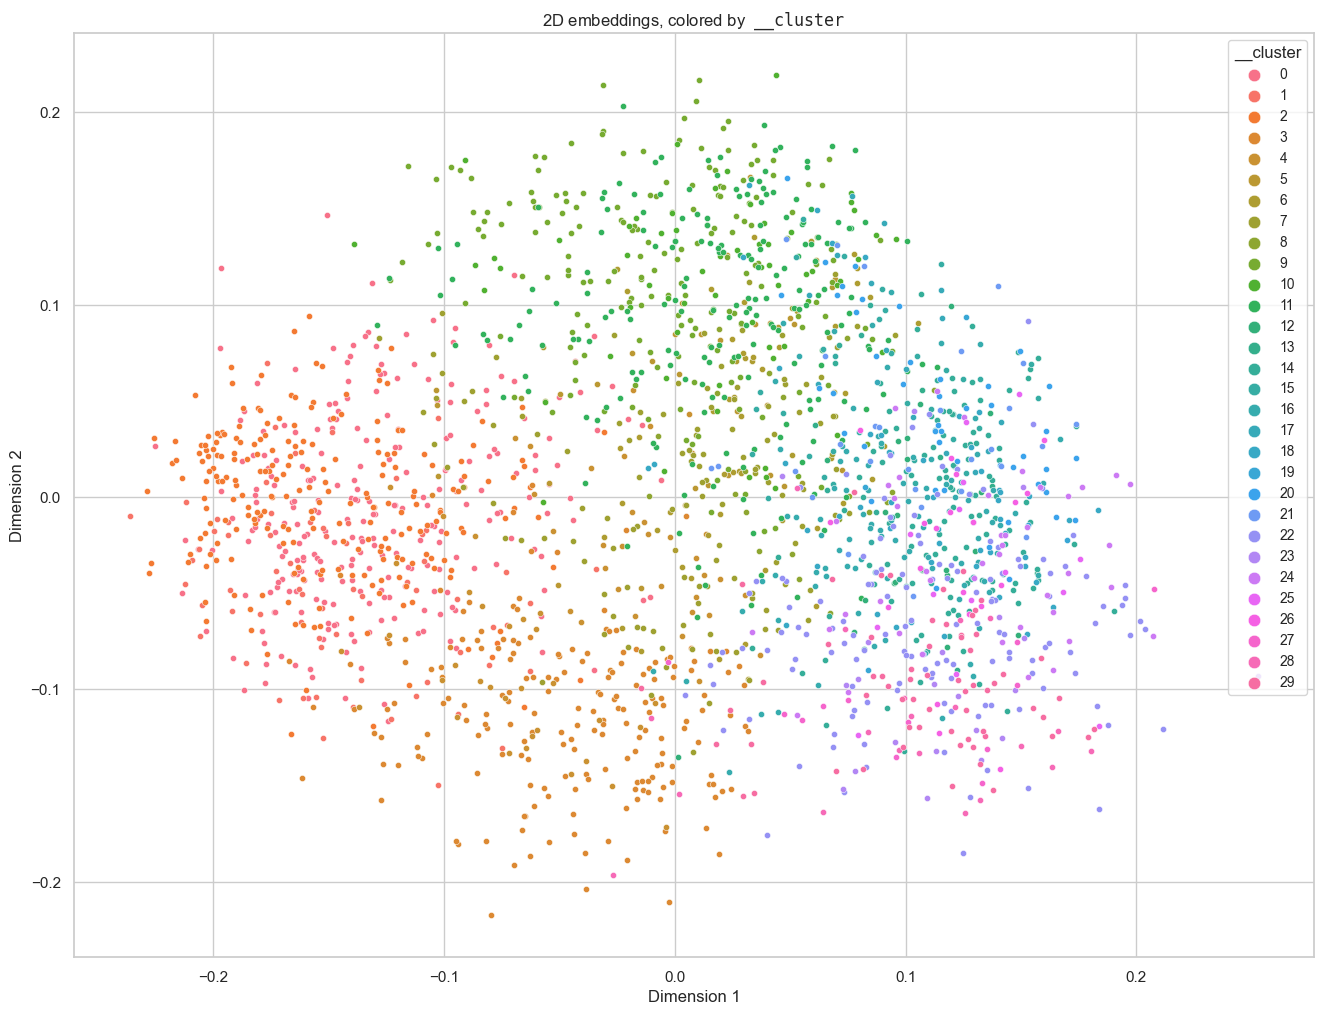

In [16]:
ds.plot_embeddings(
    embedding_field="__embedding_umap_2",
    color_by="__cluster",
    width=16,
    height=12,
    save_path="umap.png",
    dot_size=20
)

We can see that clusters certainly aren't perfectly separated in this 2-D embedding space, but you can definitely notice some boundaries. Getting a "good" clustering requires iterating, inspecting your data, and even trying out your downstream task to see how well deduplication is working. (For example, we might consider doing UMAP -> HDBSCAN instead of PCA -> K-means). Galactic provides the tools so you can try all these out with no boilerplate! For now, we'll save this dataset and call it a day.

In [17]:
ds = ds.select_columns(["instruction", "input", "output"]).save("alpaca_cleaned.csv", overwrite=True)

Map:   0%|          | 0/2266 [00:00<?, ? examples/s]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]